### 🎯 Similitudes de los pesos 
Vamos a estudiar las similitudes de los pesos de las distintas capas de un modelo entrenado con todos los datos, y el modelo entrenado únicamente con los datos a retener.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.utils import split_dataset
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

Using TensorFlow backend


In [2]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [3]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4227563520
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

___
Descargamos los modelos.

In [4]:
full_model = keras.saving.load_model('resnet18_cifar10.keras')
print(full_model.summary(expand_nested=True))

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_backbone_full (Res  (None, 1, 1, 512)         11186112  
 NetBackbone)                                                    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 32, 32, 3)]       0        |
|                                                               |
| conv1_conv (Conv2D)        (None, 16, 16, 64)        9408     |
|                                                               |
| conv1_bn (BatchNormalizat  (None, 16, 16, 64)        256      |
| ion)                                                          |
|                                                               |
| conv1_relu (Activation)    (None, 16, 16, 64)        0        |
|                                                               |
| pool1_pool (MaxPooling2D)  (None, 8, 8, 64)          0

In [5]:
retain_model = keras.saving.load_model('resnet18_cifar10_retain.keras')
print(retain_model.summary(expand_nested=True))

Model: "retain_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_backbone_retain (R  (None, 1, 1, 512)         11186112  
 esNetBackbone)                                                  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)       [(None, 32, 32, 3)]       0        |
|                                                               |
| conv1_conv (Conv2D)        (None, 16, 16, 64)        9408     |
|                                                               |
| conv1_bn (BatchNormalizat  (None, 16, 16, 64)        256      |
| ion)                                                          |
|                                                               |
| conv1_relu (Activation)    (None, 16, 16, 64)        0        |
|                                                               |
| pool1_pool (MaxPooling2D)  (None, 8, 8, 64)         

___
Descargamos y preparamos los modelos y sus capas.

In [84]:
# Extract the 'res_net_backbone' layer
res_net_backbone = full_model.get_layer('res_net_backbone_full')

# Extract layer names and weights for the backbone
backbone_layer_names = [layer.name for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]
backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

# Extract layer names and weights for the entire model
layer_names = [layer.name for layer in full_model.layers]
layer_weights = [layer.get_weights() for layer in full_model.layers]

# Replace 'res_net_backbone' with its expanded layers that have weights
expanded_layer_names = []
full_model_weights = []

for name, weights in zip(layer_names, layer_weights):
    if name == 'res_net_backbone_full':
        expanded_layer_names.extend(backbone_layer_names)
        full_model_weights.extend(backbone_layer_weights)
    elif weights:  # Only add layers that have weights
        expanded_layer_names.append(name)
        full_model_weights.append(weights)

# Print or store the expanded layer names and weights
print("Expanded Layer Names:", expanded_layer_names)


Expanded Layer Names: ['conv1_conv', 'v2_stack_0_block1_1_conv', 'v2_stack_0_block1_2_conv', 'v2_stack_0_block2_1_conv', 'v2_stack_0_block2_2_conv', 'v2_stack_1_block1_1_conv', 'v2_stack_1_block1_0_conv', 'v2_stack_1_block1_2_conv', 'v2_stack_1_block2_1_conv', 'v2_stack_1_block2_2_conv', 'v2_stack_2_block1_1_conv', 'v2_stack_2_block1_0_conv', 'v2_stack_2_block1_2_conv', 'v2_stack_2_block2_1_conv', 'v2_stack_2_block2_2_conv', 'v2_stack_3_block1_1_conv', 'v2_stack_3_block1_0_conv', 'v2_stack_3_block1_2_conv', 'v2_stack_3_block2_1_conv', 'v2_stack_3_block2_2_conv', 'dense_full']


In [85]:
# Extract the 'res_net_backbone' layer
res_net_backbone = retain_model.get_layer('res_net_backbone_retain')

# Extract layer names and weights for the backbone
backbone_layer_names = [layer.name for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]
backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

# Extract layer names and weights for the entire model
layer_names = [layer.name for layer in retain_model.layers]
layer_weights = [layer.get_weights() for layer in retain_model.layers]

# Replace 'res_net_backbone' with its expanded layers that have weights
expanded_layer_names = []
retain_model_weights = []

for name, weights in zip(layer_names, layer_weights):
    if name == 'res_net_backbone_retain':
        expanded_layer_names.extend(backbone_layer_names)
        retain_model_weights.extend(backbone_layer_weights)
    elif weights:  # Only add layers that have weights
        expanded_layer_names.append(name)
        retain_model_weights.append(weights)

# Print or store the expanded layer names and weights
print("Expanded Layer Names:", expanded_layer_names)

Expanded Layer Names: ['conv1_conv', 'v2_stack_0_block1_1_conv', 'v2_stack_0_block1_2_conv', 'v2_stack_0_block2_1_conv', 'v2_stack_0_block2_2_conv', 'v2_stack_1_block1_1_conv', 'v2_stack_1_block1_0_conv', 'v2_stack_1_block1_2_conv', 'v2_stack_1_block2_1_conv', 'v2_stack_1_block2_2_conv', 'v2_stack_2_block1_1_conv', 'v2_stack_2_block1_0_conv', 'v2_stack_2_block1_2_conv', 'v2_stack_2_block2_1_conv', 'v2_stack_2_block2_2_conv', 'v2_stack_3_block1_1_conv', 'v2_stack_3_block1_0_conv', 'v2_stack_3_block1_2_conv', 'v2_stack_3_block2_1_conv', 'v2_stack_3_block2_2_conv', 'dense_1_retain']


___
Calculamos CosSim de los parámetros para cada capa.

In [104]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

In [103]:
layer_names=['conv1',
 '0_1_1_conv',
 '0_1_2_conv',
 '0_2_1_conv',
 '0_2_2_conv',
 '1_1_1_conv',
 '1_1_0_conv',
 '1_1_2_conv',
 '1_2_1_conv',
 '1_2_2_conv',
 '2_1_1_conv',
 '2_1_0_conv',
 '2_1_2_conv',
 '2_2_1_conv',
 '2_2_2_conv',
 '3_1_1_conv',
 '3_1_0_conv',
 '3_1_2_conv',
 '3_2_1_conv',
 '3_2_2_conv',
 'dense_out']

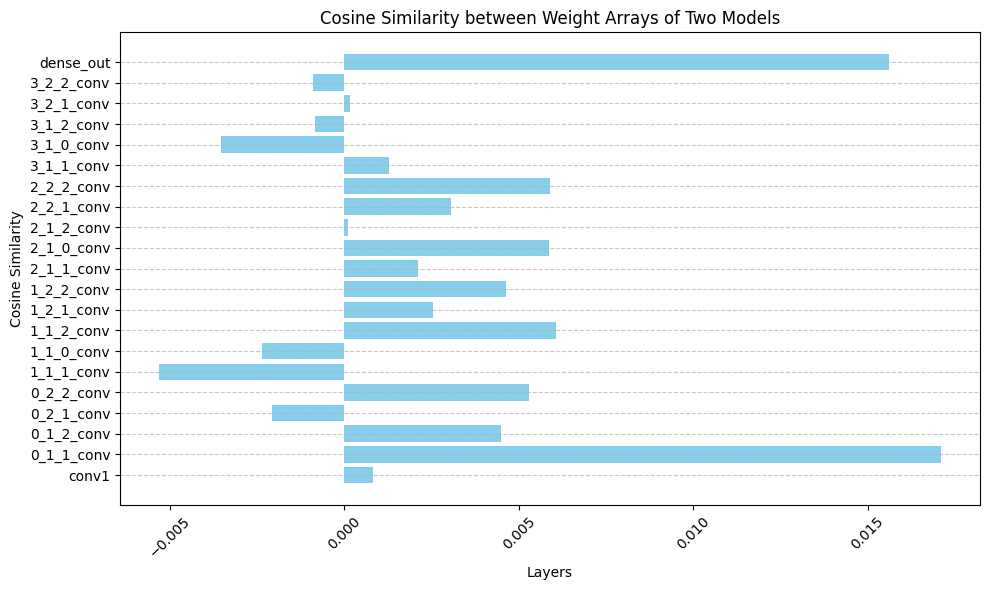

In [107]:
import matplotlib.pyplot as plt
from datetime import datetime

# Initialize list to store cosine similarities
similarities = []

def flatten_arrays(arrays):
    flattened_elements = []
    for arr in arrays:
        flattened_elements.extend(arr.flatten())
    return flattened_elements

# Compute cosine similarity for each layer
for w1, w2 in zip(full_model_weights, retain_model_weights):
    w1=flatten_arrays(w1)
    w2=flatten_arrays(w2)
    similarity = cos_sim(w1, w2)
    similarities.append(similarity)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(layer_names, similarities, color='skyblue')
plt.xlabel('Layers')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Weight Arrays of Two Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()